In [1]:
import numpy as np
import os, sys, shutil
import scipy.ndimage as snd
import h5py
import SimpleITK as sitk
from shutil import copy
import nibabel as nib
import skimage.morphology as morph
from skimage.feature import canny
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

/Users/cnmc/anaconda3/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [151]:
selem = morph.disk(2)
def getWeightMap(label):
    label = np.argmax(label, axis=3)[0]
    edge = np.float32(morph.binary_dilation(canny(np.float32(label)), selem))
    weight_map = np.zeros(label.shape)
    weight_map[np.where(label>0)] = 7
    weight_map = weight_map + 1
    weight_map[np.where(edge==1.0)] = 25
#     weight_map[np.where(label == 2.0)] = 15
    return np.uint8(weight_map[None,:,:])

def downSampleImage(image):
    return np.float64(snd.interpolation.zoom(image, 0.5))

def loadDicomVolume(file_path, itk_image):
    reader = sitk.ImageSeriesReader()
    reader.SetOutputPixelType(sitk.sitkFloat32)
    dicom_names = reader.GetGDCMSeriesFileNames(file_path)
    reader.SetFileNames(dicom_names)
    itk_image = reader.Execute()
    image_vol = sitk.GetArrayFromImage(self.itk_image)
    image_vol = np.transpose(image_vol,(1,2,0))
    return np.float32(image_vol)

def histogram_equalization(arr):
    nbr_bins = 256
    imhist, bins = np.histogram(arr.flatten(), nbr_bins, normed = True)
    cdf = imhist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    original_shape = arr.shape
    arr = np.interp(arr.flatten(), bins[:-1], cdf)
    out_arr = arr.reshape(original_shape)
    return out_arr

def normalize(x):
    x = np.float32(x)
    min_val = np.min(x)
    max_val = np.max(x)
    ret_val = (x - min_val) / (max_val - min_val)
    return ret_val

def downSample1(slc):
    return snd.interpolation.zoom(slc,0.5)

def makeLablel(lbl, num_class = 3):
    if num_class == 2:
        lbl[lbl==2] = 1
    
    lbl = oneHot(lbl,num_class)
    return np.uint8(lbl[None,:,:])

def get_z_minmaxforbrain(lbl):
    lbl[lbl==2] = 1
    maxes = np.max(lbl,axis =(1,2))
    nonzero_maxes = np.nonzero(maxes)[0]
    mn, mx = nonzero_maxes[0] - 10, nonzero_maxes[-1] + 10
    if mn < 0:
        mn = 0
    if mx >= lbl.shape[0]:
        mx = lbl.shape[0]-1
    return mn, mx

In [152]:
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

In [153]:
root = './raw_data/'
folders = ['Normal01/', 'Normal02/']
dest = './processed_data/hdf5_file/'

if not os.path.exists(dest):
    os.makedirs(dest)
vols, segs = [], []
for folder in folders:
    folder_path = os.path.join(root, folder)
    print(folder_path)
    for f in next(os.walk(folder_path))[2]:
        vols.append(os.path.join(folder_path, f))
    for s in next(os.walk(os.path.join(folder_path, "ManualSegmentation")))[2]:
        segs.append(os.path.join(os.path.join(folder_path, "ManualSegmentation"), s))
vols.sort()
segs.sort()
print len(vols), len(segs)

./raw_data/Normal01/
./raw_data/Normal02/
13 13


In [159]:
oneHot

0

In [160]:
for vol_path in tqdm(vols):
#     print("working on : " + vol_path)
    label_path = vol_path[:20] + "ManualSegmentation/mask"+vol_path.split("/").pop()
    vol_img = sitk.ReadImage(vol_path)
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))
    vol = sitk.GetArrayFromImage(vol_img)
    
#     vol = histogram_equalization(vol1)
    vol = normalize(vol)
    
    z_min, z_max = get_z_minmaxforbrain(label)
    for i in range(z_min, z_max):
        slc = np.expand_dims(vol[i,:,:],axis = 3)
        slc = np.expand_dims(slc,axis = 0)
        lbl = makeLablel(label[i,:,:],2)
        weight_map = np.expand_dims(getWeightMap(lbl),axis=3)
        
#         print slc.shape, lbl.shape, weight_map.shape
        if i == z_min + z_max//2: imshow(np.squeeze(slc), np.squeeze(lbl)[:,:,1])
        hp = h5py.File(os.path.join(dest, vol_path.split("/")[2]+"_"+vol_path.split("/")[3]+'_slice_'+ str(i)+'.hdf5'),'w')
        hp.create_dataset('image', data=slc)
        hp.create_dataset('label', data=lbl)
        hp.create_dataset('weight_map', data=weight_map)
        hp.close()

  0%|          | 0/13 [00:00<?, ?it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), 2)


/Users/cnmc/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  del sys.path[0]



TypeError: 'int' object is not callable

In [18]:
def generate_train_validate_test_set(src_path, dest_path):
    """
    Split the data into 70:15:15 for train-validate-test set
    arg: path: input data path
    
    generates CSV file with slice id and corrosponding bool 
    value for train, test and validation 
    """
    SPLIT_TRAIN = 0.7
    SPLIT_VALID = 0.15    
    
    train_files = next(os.walk(src_path))[2]
    np.random.shuffle(train_files)
    
    total_samples = len(train_files)
    print "total number of samples: {}".format(total_samples)
    
    train_ = train_files[0:int(SPLIT_TRAIN*total_samples)]
    valid_ = train_files[int(SPLIT_TRAIN*total_samples): int((SPLIT_TRAIN+SPLIT_VALID)*total_samples)]
    test_ = train_files[int((SPLIT_TRAIN+SPLIT_VALID)*total_samples):]
    
    slc, train, valid, test = [], [], [], [] # to save ids and corrosponding bool values
    for slc_ in train_:
        folder_path = os.path.join(src_path, slc_)
        slc.append('.' + folder_path)
        train.append(True)
        valid.append(False)
        test.append(False)
    print "Training Set Done!!"
    
    for slc_ in valid_:
        folder_path = os.path.join(src_path, slc_)
        slc.append('.' + folder_path)
        train.append(False)
        valid.append(True)
        test.append(False)
    print "Validation Set Done!!"

    for slc_ in test_:
        folder_path = os.path.join(src_path, slc_)
        slc.append('.' + folder_path)
        train.append(False)
        valid.append(False)
        test.append(True)
    print "Test Set Done!!"
    
    data = pd.DataFrame()
    data['Slice Path'] = slc
    data['Training'] = train
    data['Testing'] = test
    data['Validation'] = valid
    data.to_csv(os.path.join(dest_path, 'train_test_split.csv'), index=False)
    print "Data Splitting Done..."
    
generate_train_validate_test_set('./processed_data/hdf5_file', './processed_data/')

total number of samples: 0
Training Set Done!!
Validation Set Done!!
Test Set Done!!
Data Splitting Done...


In [28]:
def generate_train_validate_test_set(src_path, dest_path):
    """
    Split the data into 70:15:15 for train-validate-test set
    arg: path: input data path
    """
    SPLIT_TRAIN = 0.7
    SPLIT_VALID = 0.15


    dest_path = os.path.join(dest_path,'dataset')
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    os.makedirs(os.path.join(dest_path, 'train_set'))  
    os.makedirs(os.path.join(dest_path, 'validation_set'))  
    os.makedirs(os.path.join(dest_path, 'test_set')) 
    
    
    train_folders = next(os.walk(src_path))[2]
    np.random.shuffle(train_folders)
    
    total_samples = len(train_folders)
    print total_samples
    train_ = train_folders[0:int(SPLIT_TRAIN*total_samples)]
    valid_ = train_folders[int(SPLIT_TRAIN*total_samples): int((SPLIT_TRAIN+SPLIT_VALID)*total_samples)]
    test_ = train_folders[int((SPLIT_TRAIN+SPLIT_VALID)*total_samples):]
    
    for cell in train_:
        folder_path = os.path.join(src_path, cell)
        copy(folder_path, os.path.join(dest_path, 'train_set', cell))
    print "Training Set Done!!"
    
    for cell in valid_:
        folder_path = os.path.join(src_path, cell)
        copy(folder_path, os.path.join(dest_path, 'validation_set', cell))
    print "Validation Set Done!!"

    for cell in test_:
        folder_path = os.path.join(src_path, cell)
        copy(folder_path, os.path.join(dest_path, 'test_set', cell))
    print "Test Set Done!!"
    print "Data Splitting Done..."
    
generate_train_validate_test_set('./processed_data/hdf5_file', './processed_data/')

0
Training Set Done!!
Validation Set Done!!
Test Set Done!!
Data Splitting Done...


In [29]:
import pandas as pd
data = pd.read_csv("./loaders/train_test_split.csv")
data[data['Training']]

IOError: File ./loaders/train_test_split.csv does not exist

In [1]:
import pandas as pd
from skimage.util.shape import view_as_windows
import numpy as np
import os, sys, shutil
import scipy.ndimage as snd
import h5py
import SimpleITK as sitk
from shutil import copy
import nibabel as nib
import skimage.morphology as morph
from skimage.feature import canny
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

data = pd.read_csv("./loaders/train_test_split.csv")

/Users/cnmc/anaconda3/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [83]:
window_shape=(4,4)
feature=[]
target=[]
for train_data in data[data['Training']==True]['Slice Path']:
    with h5py.File(train_data,'r') as hdf:
        image = np.squeeze(np.array(hdf.get('image')))
        mask = np.squeeze(np.array(hdf.get('weight_map')))
        B = view_as_windows(image, window_shape)
        for b in B:
            for b_ in b:
                feature.append(np.ravel(b_[:,:]))
        M = view_as_windows(mask, window_shape)
        for m in M:
            for m_ in m:
                if np.sum(m_[:,:]) > 0:
                    target.append(1)
                else:
                    target.append(0)

In [84]:
df = pd.DataFrame(feature, columns=list('ABCDEFGHIJKLMNOP'))
df['target']=target

In [76]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(df.iloc[:,:16],df.iloc[:,16])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=1)
clf.fit(df.iloc[:,:16],df.iloc[:,16])

In [86]:
test_feature=[]
for train_data in data[data['Testing']==True]['Slice Path'][:1]:
    with h5py.File(train_data,'r') as hdf:
        image = np.squeeze(np.array(hdf.get('image')))
        B = view_as_windows(image, window_shape)
        for b in B:
            for b_ in b:
                test_feature.append(b_.flatten())
df_test = pd.DataFrame(test_feature, columns=list('ABCDEFGHIJKLMNOP'))

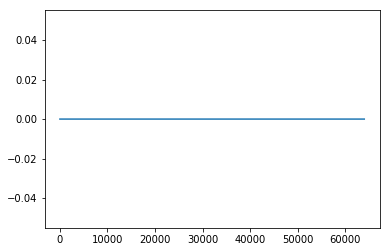

In [87]:
plt.plot(clf.predict(df_test.iloc[:,:16]))